# Import libraries

In [1]:
%matplotlib inline
%pylab inline
import numpy as np
import matplotlib.colors as colors
import matplotlib.patches as mpatches
from scipy.spatial import distance
from mpl_toolkits.axes_grid1 import make_axes_locatable
np.seterr(divide='ignore', invalid='ignore');

Populating the interactive namespace from numpy and matplotlib


# Functions to compute $\left\lVert \vec{B}\right\rVert$ for a oriented finite-wire

In [2]:
# -----------------------------------------------------------
# Magnitude of the magnetic field of a oriented finite-wire 
# inputs: x,y  : coordinates to evaluate the field
#         wire : 3D array with the coordinates of the end points of the wire  
#         I    : the electric current (default value 10A)
# -----------------------------------------------------------
def MagneticField(x,y,wire, I = 10):
    mu0 = 4*np.pi*1e-7
    c   = mu0*I/(4*np.pi)
    xA, yA = wire[0][0], wire[0][1]
    xB, yB = wire[1][0], wire[1][1]
    r1    =  np.sqrt((x-xA)**2+(y-yA)**2) 
    r2    =  np.sqrt((x-xB)**2+(y-yB)**2) 
    L     =  np.sqrt((xB-xA)**2+(yB-yA)**2) 
    CosTheta1 = (r2**2 - r1**2 - L**2)/(2*L*r1) 
    CosTheta2 = (r2**2 - r1**2 + L**2)/(2*L*r2)
    distance  = np.sqrt(2*r1**2*r2**2+2*r1**2*L**2+2*r2**2*L**2-r1**4-r2**4-L**4)/(2*L)
    Bfield    = c*(CosTheta2 - CosTheta1)/distance
    return Bfield


# -----------------------------------------------------------
# Magnitude of the magnetic field inside and outside of a finite-wire of radius r 
# inputs: I          : the electric current 
#         xp, yp, zp : coordinates to evaluate the field  
#         rA, rB     : array with the coordinates of the end points of the wire
#         radius     : radius of the wire (default 0.1m)
# -----------------------------------------------------------
def BmagpointReg(I, xp, yp, zp, rA, rB, radius=0.1):
    if rA[0]==rB[0] or rA[1]==rB[1]: 
        mu0 = 4*np.pi*1e-7
        c   = mu0*I/(4*np.pi)
        L   = np.linalg.norm(rB - rA)
        r1  = np.sqrt((xp-rA[0])**2+(yp-rA[1])**2+(zp-rA[2])**2)
        r2  = np.sqrt((xp-rB[0])**2+(yp-rB[1])**2+(zp-rB[2])**2)
        theta1 = np.arccos((r2**2 - r1**2 - L**2)/(2*L*r1))
        theta2 = np.arccos((r2**2 - r1**2 + L**2)/(2*L*r2))
        rho = np.sqrt(xp**2+yp**2)
        if rho > radius : 
            Bfield = c*(np.cos(theta2)-np.cos(theta1))/rho
        elif rho <= radius and zp >= rA[2] and zp <= rB[2]:   # region I
            Bfield = c*rho*(np.cos(theta2)-np.cos(theta1))/radius**2
        else : # rho <= radius and zp < rA[2] and zp > rB[2]: # region II
            Bfield = 0
    else :
        print("ERROR: This function only works for 2D cases")
        Bfield = 0
        rho = 0
    return rho, Bfield


# -----------------------------------------------------------
# Geometrical definition of a finite wire 
# inputs: rA, rB : 3D array with the coordinates of the end points of the wire
# -----------------------------------------------------------
def wire(rA, rB):
    x1, y1, z1 = rA[0], rA[1], rA[2]
    x2, y2, z2 = rB[0], rB[1], rB[2]
    L = distance.euclidean(rA,rB)
    return [x1, x2],[y1, y2],[z1,z2], L


# -----------------------------------------------------------
# Geometrical definition of a regular n-side polygon 
# inputs: sides       : number of sides (integer)
#         radius      : distance from the center to a vertex (circumscribed circle)
#         rotation    : rotation angle in degrees (default 0 degrees)
#         translation : distance to displace the polygon
# -----------------------------------------------------------
def polygon(sides, radius=1, rotation=0, translation=None):
    one_segment = 2*math.pi/sides
    points = [(math.sin(i*one_segment + rotation)*radius, math.cos(i*one_segment + rotation)*radius) for i in range(sides)]
    if translation:
        points = [[sum(pair) for pair in zip(point, translation)] for point in points]
    return points

# Magnetic field as a function of the distance 

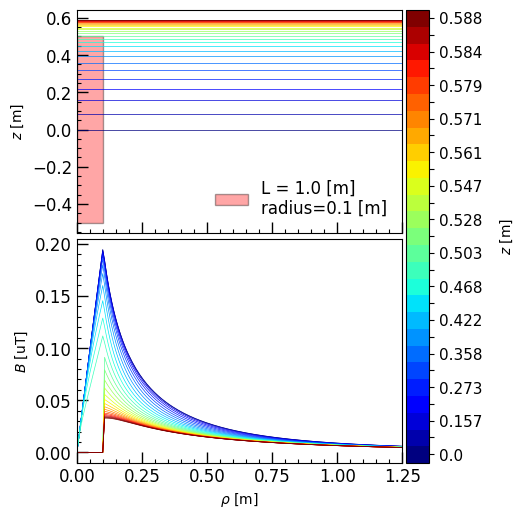

In [3]:
# define a grid to evaluate B
rA = np.array([0., 0., -0.5])
rB = np.array([0., 0., +0.5])
I = 100000.
N = 1000 # number of points
radius = 0.1

xp = np.linspace(0,5,N)
yp = np.linspace(0,5,N)
rho = np.sqrt(xp**2+yp**2)

# Create a wire
wire1 = wire(rA, rB)

#----- Plot ------
fig, axes = plt.subplots(nrows=2, ncols=1,figsize=(5,6), dpi=100,sharex=True)
fig.subplots_adjust(hspace=0.03,wspace=0.05)
axes[0].minorticks_on()
axes[0].tick_params('both', length=8, width=1, which='major', direction='in', labelsize=12)
axes[0].tick_params('both', length=3, width=0.8, which='minor', direction='in', labelsize=12)
axes[1].minorticks_on()
axes[1].tick_params('both', length=8, width=1, which='major', direction='in', labelsize=12)
axes[1].tick_params('both', length=3, width=0.8, which='minor', direction='in', labelsize=12)

axes[0].add_patch(Rectangle((rA[0], rA[2]), radius, rB[2]-rA[2], alpha=.35, edgecolor='k', facecolor='r', label="L = "+str(wire1[3])+" [m]\nradius="+str(radius)+" [m]"))

left_logspace = np.logspace(np.log10(0.01), np.log10(0.6), base=10.0, num=28)
right_logspace = 0.6 - left_logspace
height = right_logspace[::-1]

c = np.arange(1., len(height))
cmap = plt.get_cmap("jet", len(c))
norm = colors.BoundaryNorm(np.arange(len(c)+1)+0.5,len(c))
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])

ticks = []    
for ll in range(len(height)):
    zp = np.ones(N)*height[ll]
    axes[0].plot(rho,zp,'-',lw=0.5,ms=0.5,c=cmap(ll))
    BmagReg = np.array([BmagpointReg(I, xp[it], yp[it], zp[it], rA, rB, radius) for it in range(N)])
    axes[1].plot(BmagReg[:,0], BmagReg[:,1],lw=0.5,c=cmap(ll))
    ticks.append(height[ll])

axes[0].set_ylabel(r'$z$ [m]')
axes[0].legend(loc='best', fontsize=12, frameon=False, fancybox=False, ncol=1)

axes[1].set_xlabel(r'$\rho$ [m]')
axes[1].set_ylabel(r'$B$ [uT]')

axes[0].set_xlim(0,1.25)
axes[1].set_xlim(0,1.25)

ticks=numpy.around(np.array(ticks), decimals=3)
cbar = fig.colorbar(sm, ax=axes.ravel().tolist(), ticks=c, format='%.2e', pad=0.01)
for label in cbar.ax.yaxis.get_ticklabels()[1::2]:
    label.set_visible(False)
cbar.ax.set_yticklabels(ticks)
cbar.ax.tick_params(labelsize=11)
cbar.ax.set_ylabel(r'$z$ [m]', rotation=90, labelpad = 12)

plt.show()
plt.close(fig)

# Intensity map of magnetic field of a finite wire

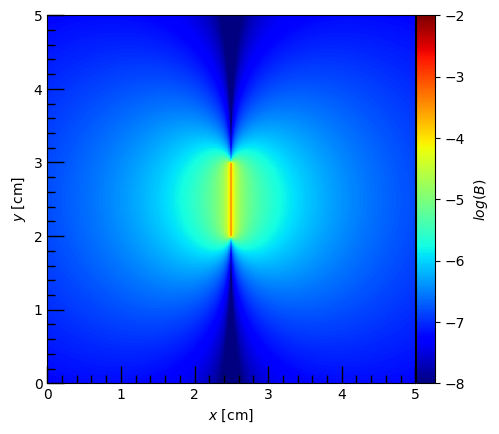

In [4]:
# set origin of the wire
Oo=[2.5, 2.5] 

# define a grid to evaluate B
x = np.linspace(0, 5, 1000)
y = np.linspace(0, 5, 1000)
[x, y] = np.meshgrid(x, y)

# create a wire
wire1 = [(Oo[0], Oo[0]-0.5), (Oo[0], Oo[0]+0.5)]

# compute B field 
B = MagneticField(x,y,  wire1)

# Plot B field
fig = plt.figure(figsize=(5,5), dpi=100)
ax = fig.add_subplot(111)
ax.minorticks_on()
ax.set_aspect(aspect=1)
ax.tick_params('both', length=12, width=1, which='major', direction='in')
ax.tick_params('both', length=6, width=1, which='minor', direction='in')

im = ax.pcolormesh(x, y, np.log10(abs(B)), vmin=-8, vmax=-2, cmap='jet')

ax.set_xlim(0,5)
ax.set_ylim(0,5)
ax.set_xticks(range(0,6))
ax.set_yticks(range(0,6))

ax.set_xlabel(r"$x$ [cm]")
ax.set_ylabel(r"$y$ [cm]")

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.01)
cb = fig.colorbar(im, ax=ax, orientation="vertical", cax=cax)
cb.set_label("$log(B)$", labelpad=5)

plt.show()

# Two parallel finite wires

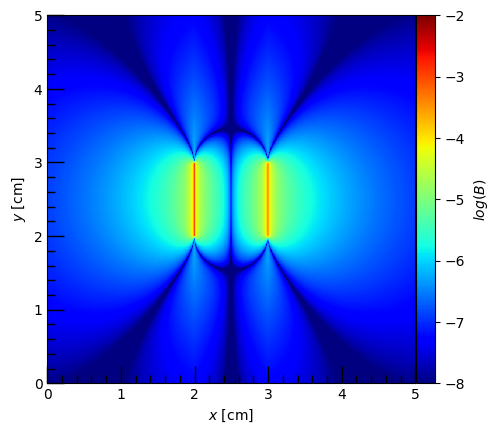

In [5]:
# define wires
wire1 = [(2, 2), (2, 3)]
wire2 = [(3, 2), (3, 3)]

# compute B field for each wire segment 
B1 = MagneticField(x,y, wire1)   
B2 = MagneticField(x,y, wire2)  

# total B field
B=B1-B2

# Plot B field intensity map
fig = plt.figure(figsize=(5,5), dpi=100)
ax = fig.add_subplot(111)
ax.minorticks_on()
ax.set_aspect(aspect=1)
ax.tick_params('both', length=12, width=1, which='major', direction='in')
ax.tick_params('both', length=6, width=1, which='minor', direction='in')

im = ax.pcolormesh(x, y, np.log10(abs(B)), vmin=-8, vmax=-2, cmap='jet')

ax.set_xlim(0,5)
ax.set_ylim(0,5)
ax.set_xticks(range(0,6))
ax.set_yticks(range(0,6))

ax.set_xlabel(r"$x$ [cm]")
ax.set_ylabel(r"$y$ [cm]")

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.01)
cb = fig.colorbar(im, ax=ax, orientation="vertical", cax=cax)
cb.set_label("$log(B)$", labelpad=5)

plt.show()
fig.clear()

# Regular triangle

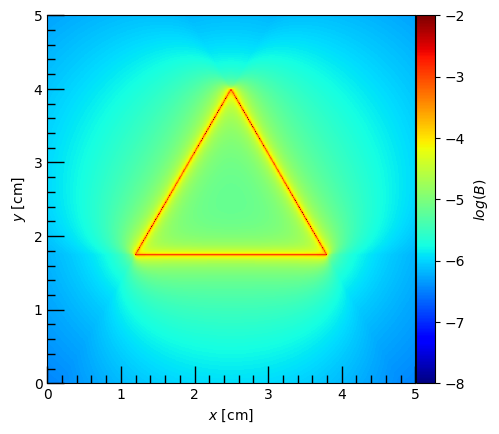

In [6]:
# create a triangle
triangle=polygon(3, 1.5, 0, Oo)  # A flat square centered on 10, 10
triangle.append(triangle[0])

# compute B field for each wire segment
B=0
counter=0
for i in range(len(triangle)-1):
    B += MagneticField(x,y, [triangle[counter],triangle[counter+1]])  # horizontal
    counter+=1

# Plot B field intensity map
fig = plt.figure(figsize=(5,5), dpi=100)
ax = fig.add_subplot(111)
ax.minorticks_on()
ax.set_aspect(aspect=1)
ax.tick_params('both', length=12, width=1, which='major', direction='in')
ax.tick_params('both', length=6, width=1, which='minor', direction='in')

im = ax.pcolormesh(x, y, np.log10(abs(B)), vmin=-8, vmax=-2, cmap='jet')

ax.set_xlim(0,5)
ax.set_ylim(0,5)
ax.set_xticks(range(0,6))
ax.set_yticks(range(0,6))

ax.set_xlabel(r"$x$ [cm]")
ax.set_ylabel(r"$y$ [cm]")

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.01)
cb = fig.colorbar(im, ax=ax, orientation="vertical", cax=cax)
cb.set_label("$log(B)$", labelpad=5)

plt.show()
fig.clear()

# Square

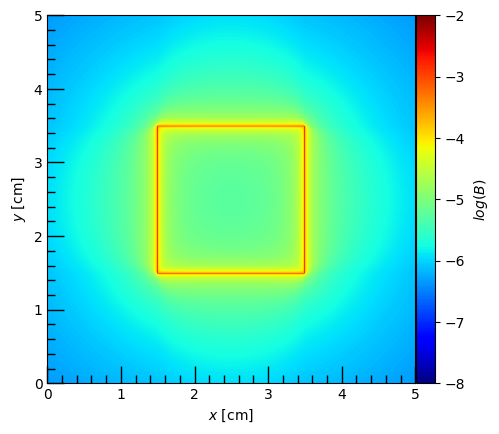

In [7]:
# create a polygon
square=polygon(4, sqrt(2), np.pi/4, Oo)  # A flat square centered on 10, 10
square.append(square[0])

# compute B field for each wire segment
B=0
counter=0
for i in range(len(square)-1):
    B += MagneticField(x,y, [square[counter],square[counter+1]])  # horizontal
    counter+=1

# Plot B field intensity map
fig = plt.figure(figsize=(5,5), dpi=100)
ax = fig.add_subplot(111)
ax.minorticks_on()
ax.set_aspect(aspect=1)
ax.tick_params('both', length=12, width=1, which='major', direction='in')
ax.tick_params('both', length=6, width=1, which='minor', direction='in')

im = ax.pcolormesh(x, y, np.log10(abs(B)), vmin=-8, vmax=-2, cmap='jet')

ax.set_xlim(0,5)
ax.set_ylim(0,5)
ax.set_xticks(range(0,6))
ax.set_yticks(range(0,6))

ax.set_xlabel(r"$x$ [cm]")
ax.set_ylabel(r"$y$ [cm]")

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.01)
cb = fig.colorbar(im, ax=ax, orientation="vertical", cax=cax)
cb.set_label("$log(B)$", labelpad=5)

plt.show()
fig.clear()

# Regular polygon

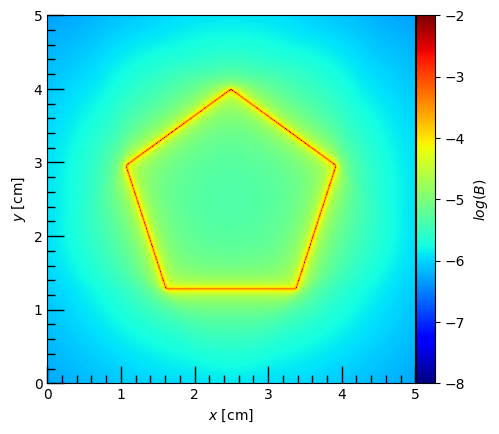

In [8]:
# create a polygon
pentagone=polygon(5, 1.5, 0, Oo)
pentagone.append(pentagone[0])

# compute B field for each wire segment
B=0
counter=0
for i in range(len(pentagone)-1):
    B += MagneticField(x,y, [pentagone[counter],pentagone[counter+1]])  # horizontal
    counter+=1

# Plot B field intensity map
fig = plt.figure(figsize=(5,5), dpi=100)
ax = fig.add_subplot(111)
ax.minorticks_on()
ax.set_aspect(aspect=1)
ax.tick_params('both', length=12, width=1, which='major', direction='in')
ax.tick_params('both', length=6, width=1, which='minor', direction='in')

im = ax.pcolormesh(x, y, np.log10(abs(B)), vmin=-8, vmax=-2, cmap='jet') 

ax.set_xlim(0,5)
ax.set_ylim(0,5)
ax.set_xticks(range(0,6))
ax.set_yticks(range(0,6))

ax.set_xlabel(r"$x$ [cm]")
ax.set_ylabel(r"$y$ [cm]")

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.01)
cb = fig.colorbar(im, ax=ax, orientation="vertical", cax=cax)
cb.set_label("$log(B)$", labelpad=5)

plt.show()
fig.clear()

# Circle

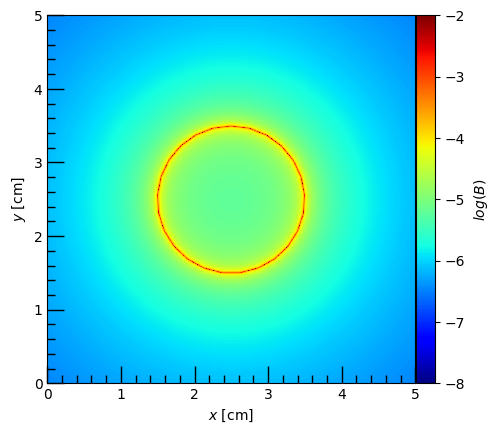

In [9]:
# creating polygon
circle=polygon(25, 1, 0, Oo)
circle.append(circle[0])

# compute B field for each wire segment
B=0
counter=0
for i in range(len(circle)-1):
    B += MagneticField(x,y, [circle[counter],circle[counter+1]])  # horizontal
    counter+=1

# Plot B field intensity map
fig = plt.figure(figsize=(5,5), dpi=100)
ax = fig.add_subplot(111)
ax.minorticks_on()
ax.set_aspect(aspect=1)
ax.tick_params('both', length=12, width=1, which='major', direction='in')
ax.tick_params('both', length=6, width=1, which='minor', direction='in')

im = ax.pcolormesh(x, y, np.log10(abs(B)), vmin=-8, vmax=-2, cmap='jet')

ax.set_xlim(0,5)
ax.set_ylim(0,5)
ax.set_xticks(range(0,6))
ax.set_yticks(range(0,6))

ax.set_xlabel(r"$x$ [cm]")
ax.set_ylabel(r"$y$ [cm]")

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.01)
cb = fig.colorbar(im, ax=ax, orientation="vertical", cax=cax)
cb.set_label("$log(B)$", labelpad=5)

plt.show()
fig.clear()

# An arbitrary geometry

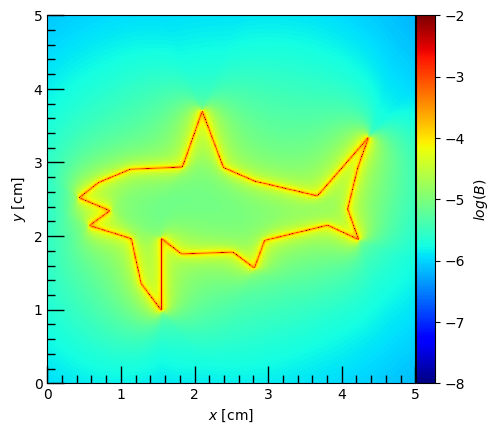

In [10]:
# create a polygon
shark=[[0.8554711673699016, 2.3484659976432134],
[0.4370464135021097, 2.5251537613562935],
[0.7016385372714486, 2.7326318090242148],
[1.132369901547117, 2.9125981677880417],
[1.8400000000000003, 2.9434834834834844],
[2.1097198781059543, 3.701531879981248],
[2.3968741209564, 2.9362491922302056],
[2.8224777308954527, 2.75020476172375],
[3.6736849507735587, 2.550162947757885],
[4.3659317862165965, 3.342688067814651],
[4.222354664791374, 2.9354770593378197],
[4.083905297702766, 2.371879442733874],
[4.232610173464604, 1.9579766158563632],
[3.8121343178621663, 2.151861164962432],
[2.9557993436474455, 1.9452265239923472],
[2.8173499765588375, 1.5693165950760894],
[2.525067979371777, 1.7871570621254174],
[1.827693389592124, 1.761003535180751],
[1.5559224097515238, 1.9711028750269266],
[1.5559224097515238, 0.9935628349868857],
[1.2790236755743085, 1.3600487829601757],
[1.145702062822316, 1.9695190126835707],
[0.5765213314580403, 2.1471887710495317],
[0.8554711673699016, 2.3484659976432134]]

# compute B field for each wire segment 
B=0
counter=0
for i in range(len(shark)-1):
    B += MagneticField(x,y, [shark[counter],shark[counter+1]])  # horizontal
    counter+=1

# Plot B field intensity map
fig = plt.figure(figsize=(5,5), dpi=100)
ax = fig.add_subplot(111)
ax.minorticks_on()
ax.set_aspect(aspect=1)
ax.tick_params('both', length=12, width=1, which='major', direction='in')
ax.tick_params('both', length=6, width=1, which='minor', direction='in')

im = ax.pcolormesh(x, y, np.log10(abs(B)), vmin=-8, vmax=-2, cmap='jet')

ax.set_xlim(0,5)
ax.set_ylim(0,5)
ax.set_xticks(range(0,6))
ax.set_yticks(range(0,6))

ax.set_xlabel(r"$x$ [cm]")
ax.set_ylabel(r"$y$ [cm]")

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.01)
cb = fig.colorbar(im, ax=ax, orientation="vertical", cax=cax)
cb.set_label("$log(B)$", labelpad=5)

plt.show()
fig.clear()